# TinyML - Knowledge Distillation (KD)


#### Federal University of Rio Grande do Norte

#### Name: Thommas Kevin Sales Flores


## 0. Install the libraries listed in the requirements.txt file

In [1]:
#!pip install -r requirements.txt

## 1. Importing libraries

In [2]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

# Apply ggplot style
plt.style.use('ggplot')

## 2. Load Dataset

MNIST, short for Modified National Institute of Standards and Technology database, is a widely used dataset in the field of machine learning and computer vision. It consists of a collection of handwritten digits ranging from 0 to 9, each digit being represented as a grayscale image of size 28x28 pixels. The dataset contains a total of 70,000 images, with 60,000 images used for training and 10,000 images used for testing.

link: https://www.nist.gov/itl/products-and-services/emnist-dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()


## 3. Splitting the data

In [4]:
train_images = train_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
test_images = test_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

## 4. Exploratory Data Analysis

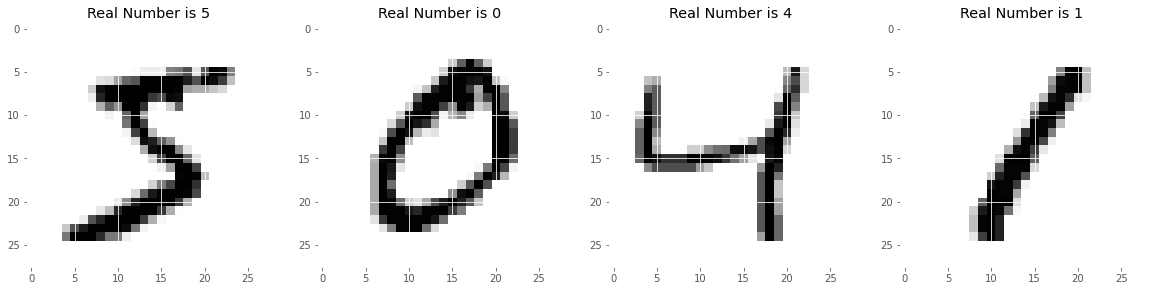

In [5]:
fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(train_images[i], cmap='binary')
    digit = train_labels[i]
    ax.set(title = f"Real Number is {digit}")

## 5. Define the models

### 5.1 Teacher Model (larger)

In [6]:
def create_teacher_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10)
    ])
    return model

In [7]:
teacher_model = create_teacher_model()

In [8]:
teacher_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

### 5.2 Student Model (smaller)

In [9]:
def create_student_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(28, 28, 1)),
        layers.Conv2D(8, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(16, activation='relu'),
        layers.Dense(10)
    ])
    return model

In [10]:
student_model = create_student_model()

In [11]:
student_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 8)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1352)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                21648     
                                                                 
 dense_3 (Dense)             (None, 10)                170       
                                                                 
Total params: 21898 (85.54 KB)
Trainable params: 21898 (85.54 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

## 6. Compile the teacher model

In [12]:
teacher_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

## 7. Training teacher model

In [13]:
history = teacher_model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels))

Epoch 1/50


1875/1875 [==============================] - 15s 8ms/step - loss: 0.1300 - accuracy: 0.9606 - val_loss: 0.0433 - val_accuracy: 0.9858
Epoch 2/50
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0423 - accuracy: 0.9864 - val_loss: 0.0380 - val_accuracy: 0.9877
Epoch 3/50
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0285 - accuracy: 0.9905 - val_loss: 0.0334 - val_accuracy: 0.9890
Epoch 4/50
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0211 - accuracy: 0.9934 - val_loss: 0.0283 - val_accuracy: 0.9900
Epoch 5/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0152 - accuracy: 0.9949 - val_loss: 0.0309 - val_accuracy: 0.9905
Epoch 6/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0124 - accuracy: 0.9961 - val_loss: 0.0355 - val_accuracy: 0.9899
Epoch 7/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.0368 - val_

In [14]:
teacher_model.save('.\models\\teacher_model.keras')

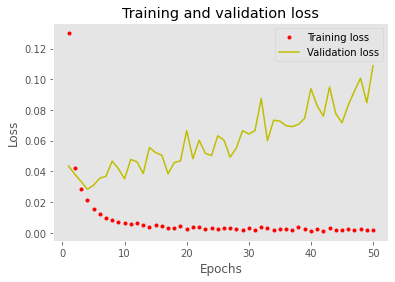

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('.\\figures\\history_teacher_model.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Distillation

In [16]:
def distillation_loss(student_logits, teacher_logits, temperature):
    teacher_probs = tf.nn.softmax(teacher_logits / temperature)
    student_probs = tf.nn.softmax(student_logits / temperature)
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(teacher_probs, student_probs))


In [17]:
def train_student_with_distillation(student_model, teacher_model, train_images, train_labels, temperature, alpha, epochs):
    optimizer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        epoch_loss_clf = 0.0  # Track classification loss
        epoch_loss_distill = 0.0  # Track distillation loss
        total_batches = 6000#len(train_images)
        
        for i in range(total_batches):
            with tf.GradientTape() as tape:
                student_logits = student_model(tf.expand_dims(train_images[i], 0))
                teacher_logits = teacher_model(tf.expand_dims(train_images[i], 0))

                # Classification loss (student vs true labels)
                loss_clf = tf.keras.losses.sparse_categorical_crossentropy(train_labels[i], student_logits, from_logits=True)

                # Distillation loss (student vs teacher predictions)
                loss_distill = distillation_loss(student_logits, teacher_logits, temperature)

                # Combine the two losses
                loss = alpha * loss_clf + (1 - alpha) * loss_distill

            gradients = tape.gradient(loss, student_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))

            # Accumulate losses for the epoch (reduce_mean to ensure scalar values)
            epoch_loss_clf += tf.reduce_mean(loss_clf)
            epoch_loss_distill += tf.reduce_mean(loss_distill)

        # Calculate average losses for the epoch
        avg_loss_clf = epoch_loss_clf / total_batches
        avg_loss_distill = epoch_loss_distill / total_batches

        # Print the average losses for this epoch
        print(f"Epoch {epoch+1}/{epochs}, Classification Loss: {avg_loss_clf:.4f}, Distillation Loss: {avg_loss_distill:.4f}")


In [18]:
temperature = 5.0  # Temperature to smooth teacher's predictions
alpha = 0.1  # Balance between distillation and classification losses

In [19]:
train_student_with_distillation(student_model, teacher_model, train_images, train_labels, temperature, alpha, 5)

Epoch 1/5, Classification Loss: 1.1301, Distillation Loss: 0.6201
Epoch 2/5, Classification Loss: 0.8194, Distillation Loss: 0.3574
Epoch 3/5, Classification Loss: 0.6509, Distillation Loss: 0.2951
Epoch 4/5, Classification Loss: 0.5038, Distillation Loss: 0.2435
Epoch 5/5, Classification Loss: 0.3827, Distillation Loss: 0.1970


## 9. Compile the student model

In [20]:
# Compile the student model
student_model.compile(optimizer='adam', 
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                      metrics=['accuracy'])

## 10. Model Evaluation

In [21]:
# Measure the inference time of the original model
def measure_inference_time(model, x_test):
    times = []
    for _ in range(10):  
        start_time = time.time()
        model.predict(x_test[:1]) 
        times.append(time.time() - start_time)
    return np.mean(times)

### 10.1 Evaluate the teacher model

In [22]:
teacher_loss, teacher_accuracy = teacher_model.evaluate(test_images, test_labels, verbose=2)
print(f"Teacher Model - Loss: {teacher_loss:.4f}, Accuracy: {teacher_accuracy:.4f}")


313/313 - 1s - loss: 0.1089 - accuracy: 0.9904 - 941ms/epoch - 3ms/step
Teacher Model - Loss: 0.1089, Accuracy: 0.9904


In [23]:
teacher_inference_time = measure_inference_time(teacher_model, test_images)
print(f"Average inference time of the teacher model: {teacher_inference_time} seconds per sample")

1/1 [==============================] - 0s 26ms/step
Average inference time of the teacher model: 0.07912769317626953 seconds per sample


### 10.2 Evaluate the student model

In [24]:
student_loss, student_accuracy = student_model.evaluate(test_images, test_labels, verbose=2)
print(f"Student Model - Loss: {student_loss:.4f}, Accuracy: {student_accuracy:.4f}")

313/313 - 1s - loss: 0.7019 - accuracy: 0.9281 - 763ms/epoch - 2ms/step
Student Model - Loss: 0.7019, Accuracy: 0.9281


In [25]:
student_inference_time = measure_inference_time(student_model, test_images)
print(f"Average inference time of the student model: {student_inference_time} seconds per sample")

1/1 [==============================] - 0s 25ms/step
Average inference time of the student model: 0.08115952014923096 seconds per sample


## 11. Obtaining the model to be implemented in the microcontroller

### 11.1 Convert some hex value into an array for C programming

In [26]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifdef __has_attribute\n'
  c_str += '#define HAVE_ATTRIBUTE(x) __has_attribute(x)\n'
  c_str += '#else\n'
  c_str += '#define HAVE_ATTRIBUTE(x) 0\n'
  c_str += '#endif\n'
  c_str += '#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))\n'
  c_str += '#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))\n'
  c_str += '#else\n'
  c_str += '#define DATA_ALIGN_ATTRIBUTE\n'
  c_str += '#endif\n\n'

  # Declare C variable
  c_str += 'const unsigned char ' + var_name + '[]  DATA_ALIGN_ATTRIBUTE = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += 'const int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  return c_str

### 11.2 Convert model to Float32

In [27]:
def representative_dataset():
    # Yield data in the shape expected by the model
    for i in range(len(train_images)):
        input_data = np.array([train_images[i]], dtype=np.float32)
        yield [input_data]

def converter_quantization_model(model, model_name):

    # Convert the model to float32
    converter_float32 = tf.lite.TFLiteConverter.from_keras_model(model)
    converter_float32.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_float32.target_spec.supported_types = [tf.float32]
    converter_float32.representative_dataset = representative_dataset

    # Convert and save float32 model
    tflite_model_float32 = converter_float32.convert()
    with open(f".\models\{model_name}" + '_quant_float32' + '.h', 'w') as file:
        file.write(hex_to_c_array(tflite_model_float32, f".\models\{model_name}" + '_quant_float32'))
    with open(f".\models\{model_name}" + '_quant_float32.tflite', 'wb') as f:
        f.write(tflite_model_float32)

    # Get sizes
    size_model_tflite_float32 = os.path.getsize(f".\models\{model_name}" + '_quant_float32.tflite')
    size_model_h_float32 = os.path.getsize(f".\models\{model_name}" + '_quant_float32.h')
    print(f".\models\{model_name}" + f'_quant_float32.tflite: {size_model_tflite_float32} Bytes')
    print(f".\models\{model_name}" + f'_quant_float32.h: {size_model_h_float32} Bytes')

    
    return size_model_tflite_float32, size_model_h_float32


## 12. Quantized Knowledge Distillation Model Evaluation

In [28]:
def evaluate_quantization(model_path, X_test, y_test, quantization_type):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Avaliar o modelo quantizado
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    predictions = []
    processing_times = []

    X_test = np.array(X_test, dtype=np.float32)
    
    for X in X_test:
        interpreter.set_tensor(input_index, [X])       
        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        output = interpreter.get_tensor(output_index).argmax(axis=1)
        predictions.append(output[0])

    acc = accuracy_score(y_test, predictions)


    return acc, processing_time

In [29]:
models_list_name = ['student_model', 'teacher_model']
models_list = [student_model, teacher_model]

In [35]:
# Lists to hold sizes
sizes_float32 = []

# Loop through each model to get the sizes
for i in range(len(models_list)):
    size_model_tflite_float32, size_model_h_float32 = converter_quantization_model(models_list[i], models_list_name[i])
    sizes_float32.append(size_model_tflite_float32/1024.)  # Append float32 size

INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpijmhgjx6\assets


INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpijmhgjx6\assets


.\models\student_model_quant_float32.tflite: 90164 Bytes
.\models\student_model_quant_float32.h: 563971 Bytes
INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmp4v2fx60f\assets


INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmp4v2fx60f\assets


.\models\teacher_model_quant_float32.tflite: 903328 Bytes
.\models\teacher_model_quant_float32.h: 5646248 Bytes


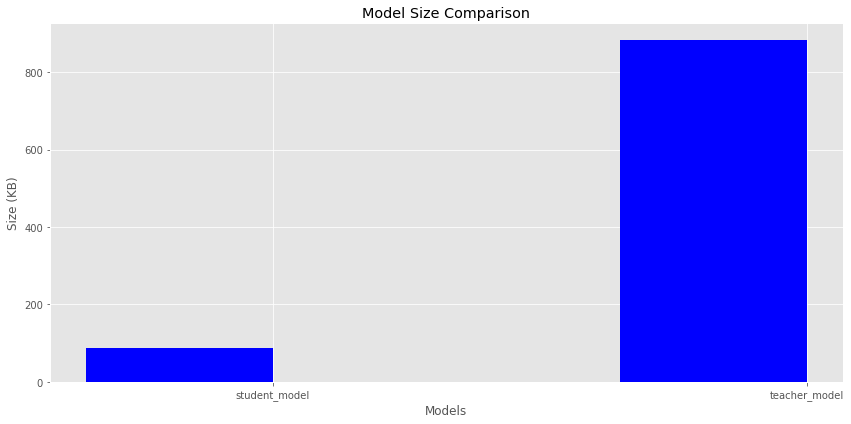

In [38]:
# Define x-axis labels for the models
x_labels = models_list_name

# Set the width of the bars
bar_width = 0.35
x = range(len(x_labels))

# Create a bar chart for the sizes
plt.figure(figsize=(12, 6))
plt.bar(x, sizes_float32, width=bar_width,  color='blue', align='center')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Size (KB)')
plt.title('Model Size Comparison')
plt.xticks([p + bar_width / 2 for p in x], x_labels)

# Show the plot
plt.tight_layout()
plt.savefig('.\\figures\\size_KD_comparative.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:

acc_float32 = []
time_float32 = []

# Loop through each model to get the sizes
for i in range(len(models_list_name )):
    acc, processing_time = evaluate_quantization(f".\models\{models_list_name[i]}" + '_quant_float32.tflite', test_images, test_labels, 'float32')
    acc_float32.append(acc)  # Append float32 size
    time_float32.append(processing_time)  # Append int8 size

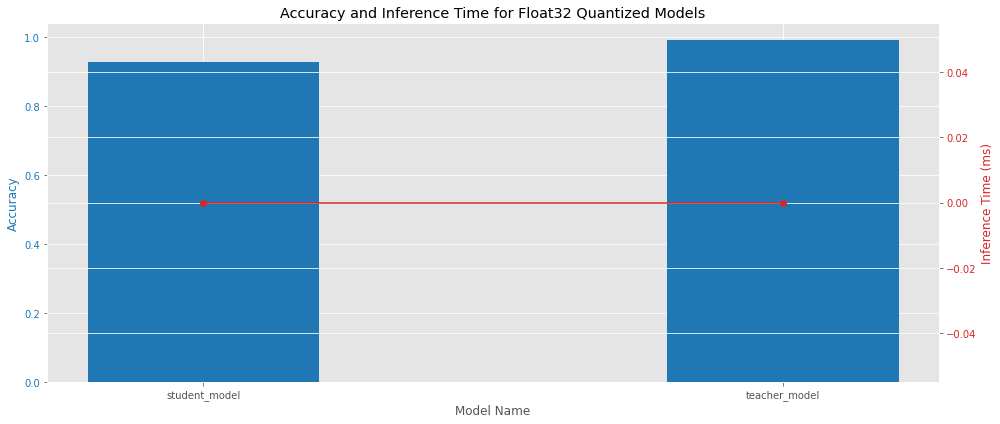

In [33]:
# Plot the accuracy vs. inference time for float32 models
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot accuracy
ax1.set_xlabel('Model Name')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.bar(models_list_name, acc_float32, color='tab:blue', width=0.4, label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for inference time
ax2 = ax1.twinx()
ax2.set_ylabel('Inference Time (ms)', color='tab:red')
ax2.plot(models_list_name, time_float32, color='tab:red', marker='o', label='Inference Time')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set title
plt.title('Accuracy and Inference Time for Float32 Quantized Models')

# Show plot
plt.tight_layout()
plt.savefig('.\\figures\\acc_quantized_model.png', dpi=300, bbox_inches='tight')
plt.show()